# Modelling Conversion

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')

In [2]:
def plot_histogram_binary_feature(df: pd.DataFrame, feature_name: str = 'converted', truth_value=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    
    sns.countplot(df[feature_name], ax=ax)
    
    N_yes = len(df[df[feature_name] == truth_value])
    N_no = len(df[df[feature_name] != truth_value])
    counts = np.array([N_no, N_yes])
    total_count = counts.sum()
    pct = (counts / counts.sum()) * 100

    for i in range(len(pct)):
        p = ax.patches[i]
        percentage = '{:.2f}%'.format(pct[i])
        x = p.get_x()
        y = np.nan_to_num(p.get_y() + p.get_height())
        ax.annotate(percentage, (x, y), fontsize=12)
    return ax

## Data Description

The data sets consists of customers that have purchased one or more audiobooks. The data was collected from an audiobook app in a period of two years. We want to predict whether the customer will convert again from the company. By targeting customers who are mostly to come back again, we can improve sales. We also want to discover the important features for conversion. Identifying prospective customers, creates value and growth opportunities.

To perform supervised learning, we need labels that show whether a customer will convert. Therefore, additional data were collected over a six months period after the two-year period. During the six-month period, we can check whether a customer bought more audiobooks and assign a label for the corresponding customer in the two-year period dataset. It is assumed that six months is a reasonable time frame to determine if a customer is likely to convert.

<img src="figures/audiobooks-data-time-line.png" width="500" />


The data consists of following columns:

- `id`: A unique identifier for the customer

- `book_length_mins_total`: Total book length is the sum of the lengths of all purchased audiobooks

- `book_length_mins_avg`:  The average book length is the total book length divided by the number of purchases. Number of audiobooks can be found by `book_length_mins_total` / `book_length_mins_avg`

- `price_total`: The total price paid by this customer

- `price_avg`: The average price for each purchase.

- `has_reviewed`: An indicator whether the customer has reviewed one of the audiobooks. A feature that whether the customer enganges with the platform. We can assume that enganged customers are more like to convert again.

- `review_score`: The average review across all purchases. The scale is from 1 to 10. Most people do not leave any review so to compensate for missing values in this column, the average review score of 8.91 is inserted. The mean value indicates the status quo. If a review score is larger than the mean then this indicates above average "feelings" while a less score indicates below average "feelings". The average review he/she left indicates his/her feelings towards the content on the medium as a whole. For example, an average score of 2 indicates the person did not have a pleasant experience with audiobooks especially if the average score in general is 8,91. We can assume that such a customer is not likely to buy again.

- `total_mins_listened`: Total minutes listened which is a measure of engagement with the platform.

- `completion`: A value between 0 to 1 indicating if the customer has listened to all their audiobooks.

- `support_requests`: The total number of support requests opened by the customer. A measure of engagement. High number of requests may indicate frustration with the platform or customers who use the platform often enough to find smaller issues with it. A customer with zero support may actually not use the app that often or is just happy with it.

- `last_visit_days_since_first_purchase`: The last time the customer visited the platform since their first purchase. A measure of engagement. The larger the number, the better. If a person engages regularly with the platform this number will be bigger. A value of zero indicates that the customer has only accessed her purchases on the first day.

- `converted`: An indicator whether the customer will convert in the future.

## Exploratory Data Analysis

In [3]:
columns = [
    'book_length_mins_total', 'book_length_mins_avg', 'price_total', 'price_avg',
    'has_reviewed', 'review_score', 'total_mins_listened', 'completion',
    'support_requests', 'last_visit_days_since_first_purchase', 'converted'
]
df_data = pd.read_csv('data/audiobook-customers.csv', names=columns, index_col=0)

In [4]:
input_features = columns[:-1]
output_feature = columns[-1]

In [5]:
df_data.head()

,book_length_mins_total,book_length_mins_avg,price_total,price_avg,has_reviewed,review_score,total_mins_listened,completion,support_requests,last_visit_days_since_first_purchase,converted
873,2160.0,2160,10.13,10.13,0,8.91,0.0,0.0,0,0,1
611,1404.0,2808,6.66,13.33,1,6.50,0.0,0.0,0,182,1
705,324.0,324,10.13,10.13,1,9.00,0.0,0.0,1,334,1
391,1620.0,1620,15.31,15.31,0,9.00,0.0,0.0,0,183,1
819,432.0,1296,7.11,21.33,1,9.00,0.0,0.0,0,0,1


The mean review score of 8.91 is relatively high. 
It would be interesting to know if the customer who leave above average review score have actually listened to more than 10 minutes of the audiobook. 

In [6]:
f_reviewed = df_data['has_reviewed'] == 1
f_gt_avg = df_data['review_score'] > 8.91
f_listened = df_data['total_mins_listened'] > 10

count_left_review = len(df_data[f_reviewed])
count_above_average_review = len(df_data[f_reviewed & f_gt_avg])
count_above_average_review_listened = len(df_data[f_reviewed & f_gt_avg & f_listened])

ratio = count_above_average_review / count_left_review

print(f'{count_left_review}: Number of customers who have left are review')
print(f'{count_above_average_review}: Number of customers with above average review score')
print(f'{ratio*100:.0f} % of customers have given above average review score.')

print(f'{count_above_average_review_listened}: Number of customer with above avg score who listened to their audiobooks.')


2264: Number of customers who have left are review
1548: Number of customers with above average review score
68 % of customers have given above average review score.
0: Number of customer with above avg score who listened to their audiobooks.


68% of customers who left a review, gave an above average score. However, none of them have listened to more than 10 minutes of the audiobooks.

### Types

In [7]:
df_data.dtypes

book_length_mins_total                  float64
book_length_mins_avg                      int64
price_total                             float64
price_avg                               float64
has_reviewed                              int64
review_score                            float64
total_mins_listened                     float64
completion                              float64
support_requests                          int64
last_visit_days_since_first_purchase      int64
converted                                 int64
dtype: object

### Data Checks and Preprocessing

In [8]:
# Check for missing values
pd.DataFrame(df_data.isnull().sum(), columns=['Number'])

,Number
book_length_mins_total,0
book_length_mins_avg,0
price_total,0
price_avg,0
has_reviewed,0
review_score,0
total_mins_listened,0
completion,0
support_requests,0
last_visit_days_since_first_purchase,0


In [9]:
# Check if any rows contain constant values
(df_data.nunique(axis=1) == 1).any()

False

In [10]:
# Check if there are any columns with a constant value
df_data.nunique(axis=0) == 1

book_length_mins_total                  False
book_length_mins_avg                    False
price_total                             False
price_avg                               False
has_reviewed                            False
review_score                            False
total_mins_listened                     False
completion                              False
support_requests                        False
last_visit_days_since_first_purchase    False
converted                               False
dtype: bool

In [11]:
# Check number of duplicate rows.
n_duplicates = len(df_data[df_data.duplicated()])
print(f'Number of duplicate rows: {n_duplicates}')

Number of duplicate rows: 3575


Remove duplicates as they can be an issue when data is split into training, validation and test sets.

In [12]:
n_before = len(df_data)
df_data.drop_duplicates(inplace=True)
n_after = len(df_data)
print(f'Removed {n_before - n_after} duplicate rows.')

Removed 3575 duplicate rows.


Next, let us determine whether the dataset is imbalanced.

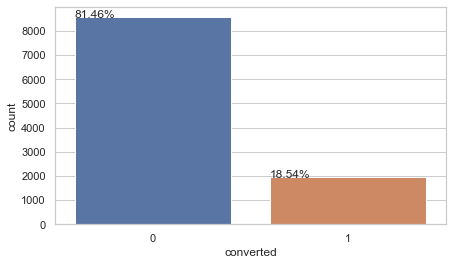

In [13]:
plot_histogram_binary_feature(df_data);

The dataset is not balanced as the distribution is roughly 1:4. When the data is imbalanced, we should avoid using the accuracy metric because it does not consider data imbalance. Other metrics such as F1 score and ROC-AUC (Area Under the Curve) are better suited. Imbalanced data increases the risk of our model performing poorly because it is biased against the majority class. This may result in a model does not model the minority class well. Although we have less data for the minority class, we are more interested in accurately predicting customer who are likely to convert.

Let us balance the dataset by subsampling the majority class.

In [14]:
df_data_grouped = df_data.groupby('converted')
N_minority_class = df_data_grouped.size().min()
df_data_balanced = df_data_grouped.apply(lambda df: df.sample(N_minority_class)).reset_index(drop=True)

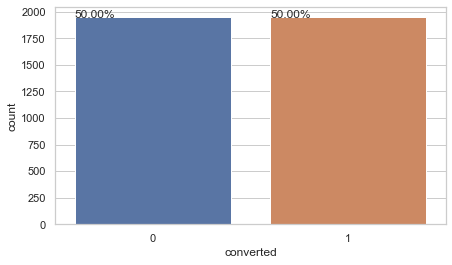

In [15]:
plot_histogram_binary_feature(df_data_balanced);

Let us shuffle and split the data:

In [16]:
X = df_data_balanced[input_features]
y = df_data_balanced[output_feature]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

Next, we scale relevant features:

In [18]:
scaler = StandardScaler()

scaler.fit(X_train)  # Calculate statistics on the training data

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The final steps include:
- select a few algorithms to try out on the data
- find the best hyper-parameter optimisation for each algorithm on the data using cross-validation (CV)
- pick the model that is likely to perform well on the test data based on the CV results
- evaluate the chosen model on the test data
- save the scaler and the model on disk
- apply it to new data e.g. `data/audiobook-customers-new.csv`